## Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
#import math
import matplotlib.pyplot as plt
import seaborn as sns
#import statsmodels.api as sm
#sns.set_context("paper", rc={"font_scale":5,"axes.titlesize":8,"axes.labelsize":15})   
sns.set_style("white",{"grid.color": "0.2", "grid.linestyle": "-","grid.linewidth": "2"})
sns.set_context("paper", font_scale=2)                                                  
                                                                                                                                                                                                                                
color = sns.color_palette("Set2", 6)
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error,mean_absolute_percentage_error,mean_squared_error
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant  

import warnings as wg
wg.filterwarnings('ignore')

## Loading Datasets

In [2]:
cal = pd.read_csv('calories.csv')
cal.head()

,User_ID,Calories
0,14733363,231.0
1,14861698,66.0
2,11179863,26.0
3,16180408,71.0
4,17771927,35.0


In [3]:
exe = pd.read_csv('exercise.csv')
exe.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8


### Combining two datasets

In [4]:
calories = pd.concat([exe, cal['Calories']], axis = 1) # axis 1 :adding data row wise 
calories.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


### Droping unnecessary column

In [5]:
calories = calories.drop(['User_ID'], axis = 1)
calories

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,female,27,154.0,58.0,10.0,81.0,39.8,35.0
...,...,...,...,...,...,...,...,...
14995,female,20,193.0,86.0,11.0,92.0,40.4,45.0
14996,female,27,165.0,65.0,6.0,85.0,39.2,23.0
14997,female,43,159.0,58.0,16.0,90.0,40.1,75.0
14998,male,78,193.0,97.0,2.0,84.0,38.3,11.0


## Preprocessing

### Observing the Dataset

In [6]:
calories.shape

(15000, 8)

In [7]:
calories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Gender      15000 non-null  object 
 1   Age         15000 non-null  int64  
 2   Height      15000 non-null  float64
 3   Weight      15000 non-null  float64
 4   Duration    15000 non-null  float64
 5   Heart_Rate  15000 non-null  float64
 6   Body_Temp   15000 non-null  float64
 7   Calories    15000 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 937.6+ KB


In [8]:
calories.isnull().sum()

Gender        0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

**No null values present in the dataset.**

### Exploring the descriptive statistics of the variables

In [9]:
#statistical measures about the data
calories.describe(include = 'all')

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,15000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,female,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,7553,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,42.789800,174.465133,74.966867,15.530600,95.518533,40.025453,89.539533
std,NaN,16.980264,14.258114,15.035657,8.319203,9.583328,0.779230,62.456978
min,NaN,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,NaN,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,35.000000
50%,NaN,39.000000,175.000000,74.000000,16.000000,96.000000,40.200000,79.000000
75%,NaN,56.000000,185.000000,87.000000,23.000000,103.000000,40.600000,138.000000


### Converting categorical data into numeric

In [10]:
calories.replace({'Gender':{'male':0, 'female': 1}}, inplace = True)

### Dealing with outliers

In [11]:
calories.columns.values

array(['Gender', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate',
       'Body_Temp', 'Calories'], dtype=object)

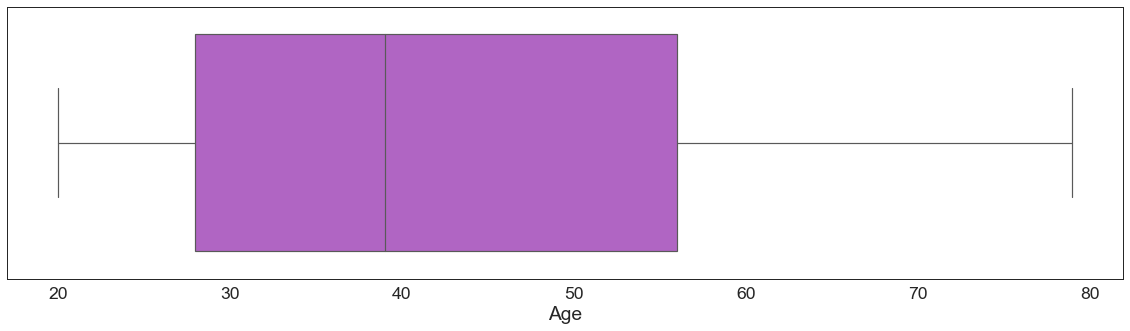

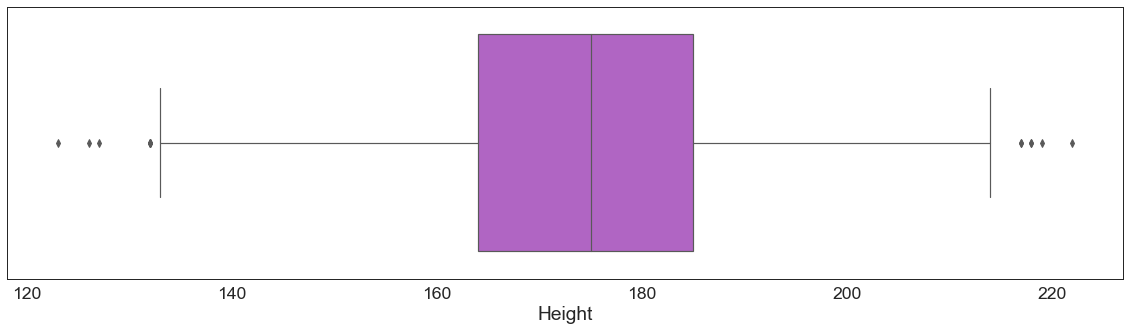

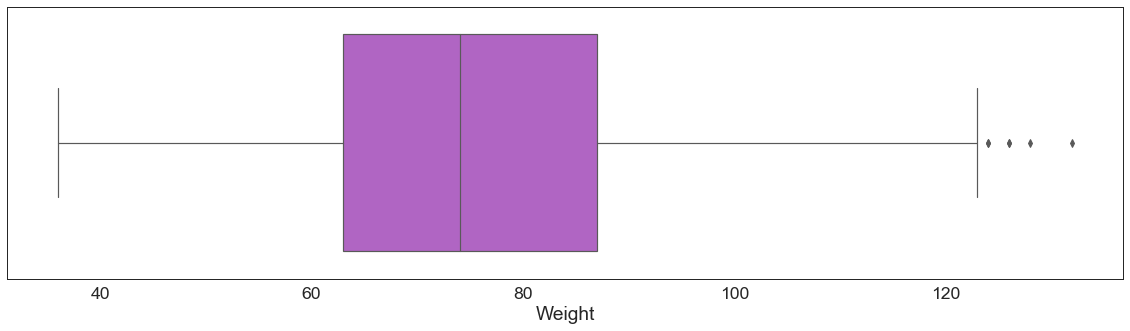

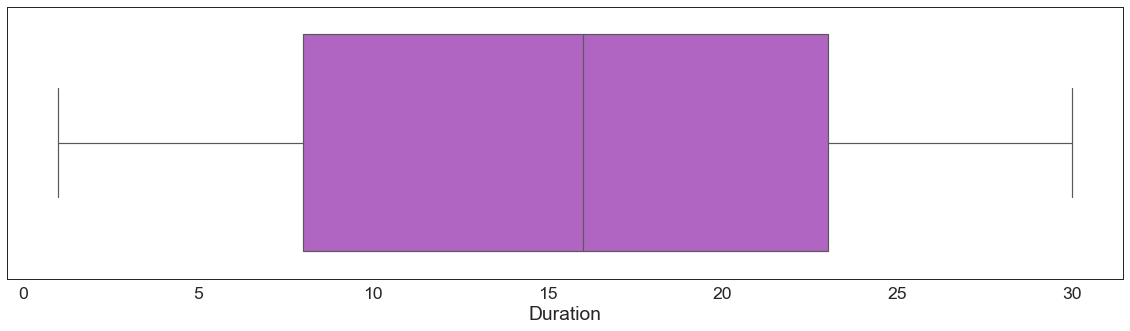

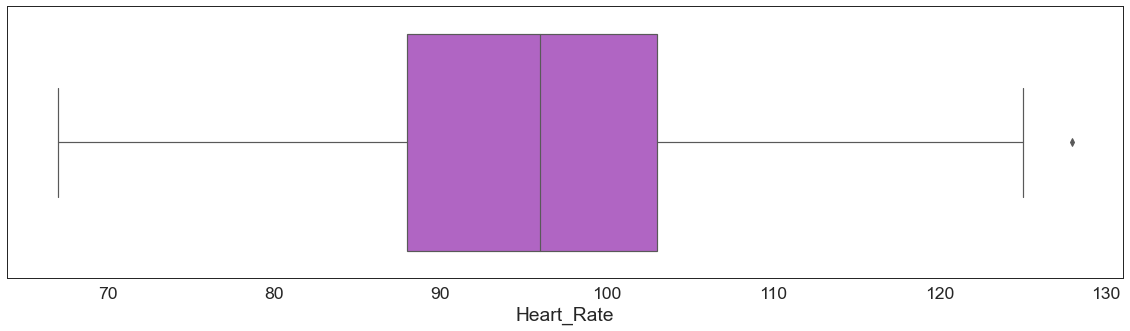

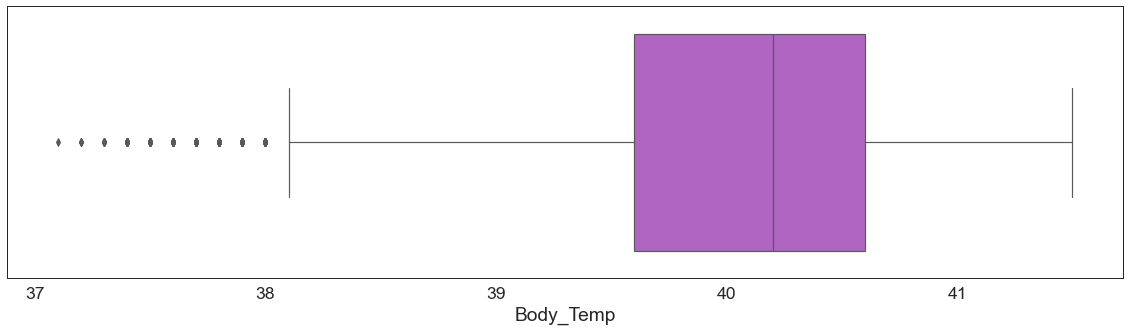

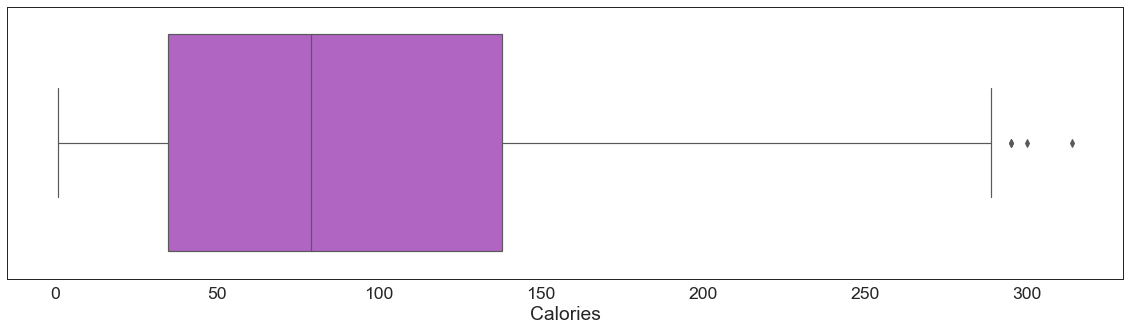

In [17]:
df = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate',
       'Body_Temp', 'Calories']
for i in df:
    fig = plt.figure(figsize=(20,5))
    sns.boxplot(calories[i], color = 'mediumorchid')
    fig.show()

**Outliers present in Height, Weight, Heart_Rate, Body_Temp and Calories columns**

### Removing outliers from Height column

In [18]:
Q1 = calories.Height.quantile(0.25)
Q3 = calories.Height.quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR
print('Q1: ' + str(Q1) +' and '+ 'Q2: '+ str(Q3))
print('IQR: '+ str(IQR))
print('lower_limit: '+str(lower_limit)+ ' and ' + 'upper_limit: ' +str(upper_limit))

Q1: 164.0 and Q2: 185.0
IQR: 21.0
lower_limit: 132.5 and upper_limit: 216.5


In [19]:
calories_H = calories[(calories.Height>lower_limit)&(calories.Height<upper_limit)]

### Removing Outliers from Weight Column

In [20]:
Q1 = calories_H.Weight.quantile(0.25)
Q3 = calories_H.Weight.quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR
print('Q1: ' + str(Q1) +' and '+ 'Q2: '+ str(Q3))
print('IQR: '+ str(IQR))
print('lower_limit: '+str(lower_limit)+ ' and ' + 'upper_limit: ' +str(upper_limit))

Q1: 63.0 and Q2: 87.0
IQR: 24.0
lower_limit: 27.0 and upper_limit: 123.0


In [21]:
calories_W = calories_H[(calories_H.Weight>lower_limit)&(calories_H.Weight<upper_limit)]

### Removing Outliers from Heart Rate column

In [22]:
Q1 = calories_W.Heart_Rate.quantile(0.25)
Q3 = calories_W.Heart_Rate.quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR
print('Q1: ' + str(Q1) +' and '+ 'Q2: '+ str(Q3))
print('IQR: '+ str(IQR))
print('lower_limit: '+str(lower_limit)+ ' and ' + 'upper_limit: ' +str(upper_limit))

Q1: 88.0 and Q2: 103.0
IQR: 15.0
lower_limit: 65.5 and upper_limit: 125.5


In [23]:
calories_W['Heart_Rate'] = winsorize(calories_W['Heart_Rate'], limits = (0, 0.10))

### Removing Outliers from Body Temp column

In [24]:
Q1 = calories_W.Body_Temp.quantile(0.25)
Q3 = calories_W.Body_Temp.quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR
print('Q1: ' + str(Q1) +' and '+ 'Q2: '+ str(Q3))
print('IQR: '+ str(IQR))
print('lower_limit: '+str(lower_limit)+ ' and ' + 'upper_limit: ' +str(upper_limit))

Q1: 39.6 and Q2: 40.6
IQR: 1.0
lower_limit: 38.1 and upper_limit: 42.1


In [25]:
calories_W['Body_Temp']=winsorize(calories_W['Body_Temp'], limits=(0.10,0))

### Removing Outliers from Calories column

In [26]:
Q1 = calories_W.Calories.quantile(0.25)
Q3 = calories_W.Calories.quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR
print('Q1: ' + str(Q1) +' and '+ 'Q3: '+ str(Q3))
print('IQR: '+ str(IQR))
print('lower_limit: '+str(lower_limit)+ ' and ' + 'upper_limit: ' +str(upper_limit))

Q1: 35.0 and Q3: 138.0
IQR: 103.0
lower_limit: -119.5 and upper_limit: 292.5


In [27]:
calories_C = calories_W[(calories_W.Calories > lower_limit) & (calories_W.Calories < upper_limit)]

In [28]:
calories_C.head()

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,68,190.0,94.0,29.0,105.0,40.8,231.0
1,1,20,166.0,60.0,14.0,94.0,40.3,66.0
2,0,69,179.0,79.0,5.0,88.0,38.9,26.0
3,1,34,179.0,71.0,13.0,100.0,40.5,71.0
4,1,27,154.0,58.0,10.0,81.0,39.8,35.0


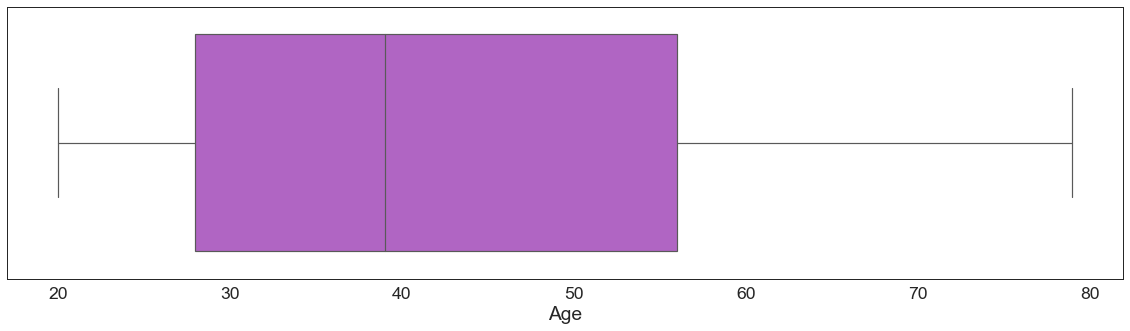

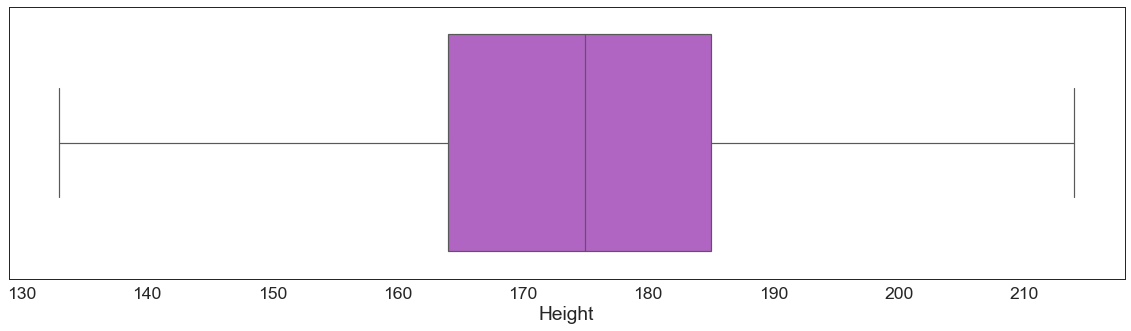

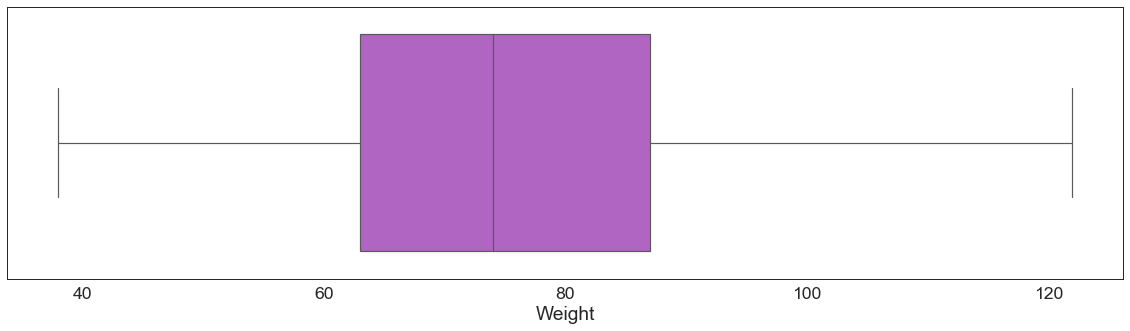

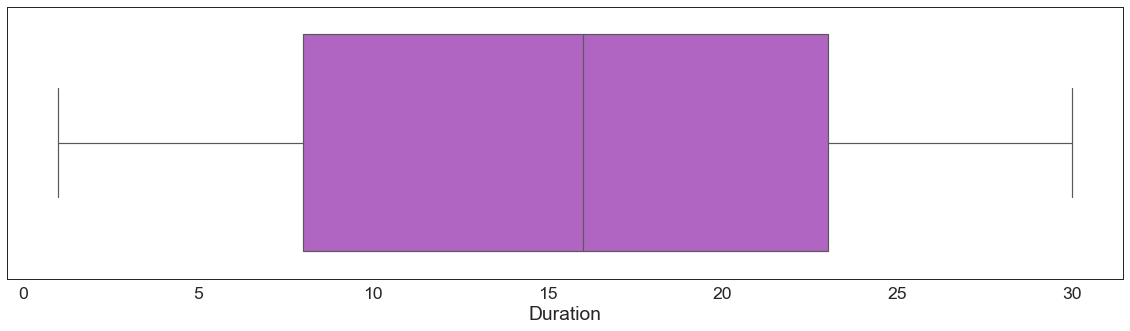

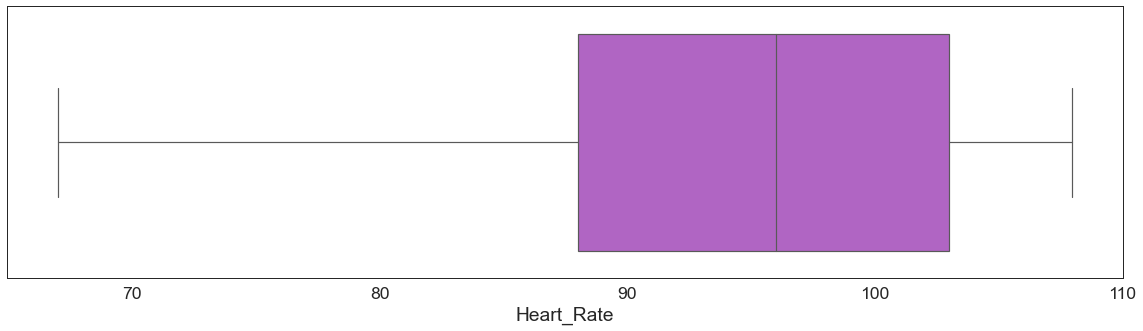

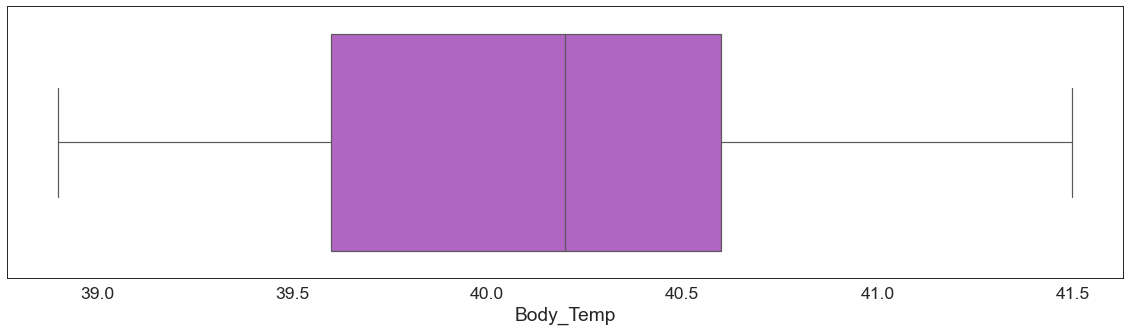

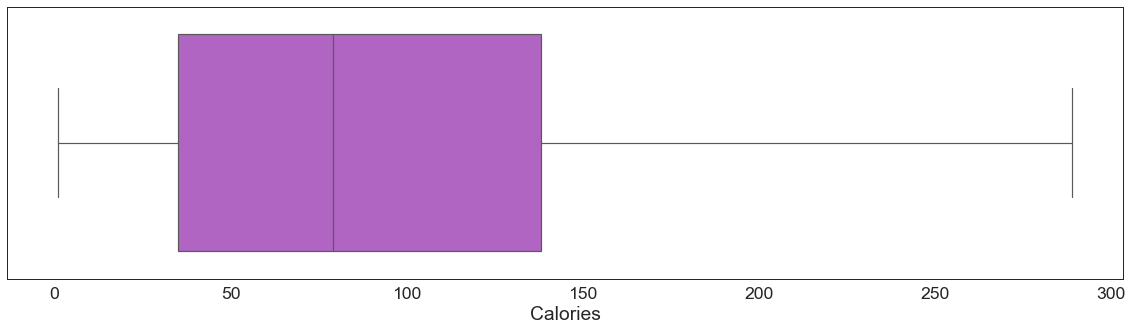

In [29]:
df = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate',
       'Body_Temp', 'Calories']
for i in df:
    fig = plt.figure(figsize=(20,5))
    sns.boxplot(calories_C[i], color = 'mediumorchid')
    fig.show()

**All outliers are remove from the dataset.**

In [30]:
df1 = calories_C.copy() 

In [31]:
df1.head()

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,68,190.0,94.0,29.0,105.0,40.8,231.0
1,1,20,166.0,60.0,14.0,94.0,40.3,66.0
2,0,69,179.0,79.0,5.0,88.0,38.9,26.0
3,1,34,179.0,71.0,13.0,100.0,40.5,71.0
4,1,27,154.0,58.0,10.0,81.0,39.8,35.0


In [32]:
df1.shape

(14979, 8)

**After removing outliers sample size is 14979.**

In [33]:
df1.describe(include = 'all')

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,14979.000000,14979.000000,14979.000000,14979.000000,14979.000000,14979.000000,14979.000000,14979.000000
mean,0.503705,42.780359,174.459777,74.951666,15.528941,95.161025,40.080953,89.486414
std,0.500003,16.976544,14.189583,14.970833,8.316802,8.986361,0.657959,62.362308
min,0.000000,20.000000,133.000000,38.000000,1.000000,67.000000,38.900000,1.000000
25%,0.000000,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,35.000000
50%,1.000000,39.000000,175.000000,74.000000,16.000000,96.000000,40.200000,79.000000
75%,1.000000,56.000000,185.000000,87.000000,23.000000,103.000000,40.600000,138.000000
max,1.000000,79.000000,214.000000,122.000000,30.000000,108.000000,41.500000,289.000000


### Correlation

In [34]:
correlation = df1.corr()
correlation

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
Gender,1.000000,-0.002665,-0.711203,-0.784120,-0.003161,-0.011589,-0.005722,-0.021622
Age,-0.002665,1.000000,0.008966,0.089802,0.012323,0.010525,0.010007,0.152983
Height,-0.711203,0.008966,1.000000,0.958272,-0.004615,0.001080,0.000298,0.017151
Weight,-0.784120,0.089802,0.958272,1.000000,-0.001828,0.004783,0.002551,0.035099
Duration,-0.003161,0.012323,-0.004615,-0.001828,1.000000,0.854972,0.932585,0.955797
Heart_Rate,-0.011589,0.010525,0.001080,0.004783,0.854972,1.000000,0.806072,0.885176
Body_Temp,-0.005722,0.010007,0.000298,0.002551,0.932585,0.806072,1.000000,0.865645
Calories,-0.021622,0.152983,0.017151,0.035099,0.955797,0.885176,0.865645,1.000000


In [35]:
correlation = df1.corr()
correlation['Calories'].sort_values(ascending = True)

Gender       -0.021622
Height        0.017151
Weight        0.035099
Age           0.152983
Body_Temp     0.865645
Heart_Rate    0.885176
Duration      0.955797
Calories      1.000000
Name: Calories, dtype: float64

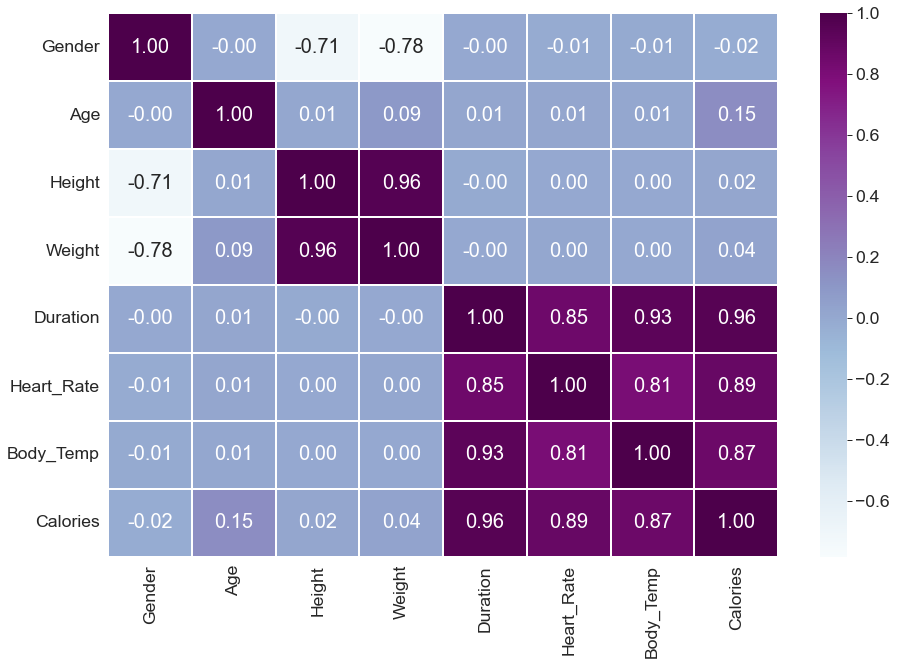

In [36]:
plt.figure(figsize=(15,10))

sns.heatmap(correlation, cbar = True, linecolor = 'white', 
            linewidth = 2, annot = True, annot_kws={"size":20}, 
            cmap = 'BuPu', fmt = '.2f')
plt.show()

**According to the heatmap, Weight and Height columns have a high correlation but we will combine them and put them into BMI column. So we can drop Weight and Height columns.**

### Multicollinearity

- Variance inflation factor (VIF) is a measure of the amount of multicollinearity in a set of multiple regression variables

In [37]:
# compute the vif for all given features
def compute_vif(considered_features):
    
    X = df1[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variables']!='intercept']
    return vif

In [38]:
# features to consider removing
considered_features = ['Gender', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate','Body_Temp']


# compute vif 
compute_vif(considered_features).sort_values('VIF', ascending=False)


,Variables,VIF
3,Weight,18.624216
2,Height,14.227214
4,Duration,10.018075
6,Body_Temp,7.693641
5,Heart_Rate,3.726435
0,Gender,2.831454
1,Age,1.125471


**As we can see, height and weight have very high values of VIF, indicating that these two variables are highly correlated. This is expected as the weight of a person does influence their height. Hence, considering these two features together leads to a model with high multicollinearity.**

In [39]:
for data in [df1]:         # adding BMI column to both training and test sets
    data["BMI"] = data["Weight"] / ((data["Height"] / 100) ** 2)
    data["BMI"] = round(data["BMI"] , 2)

In [40]:
df1.head()

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,BMI
0,0,68,190.0,94.0,29.0,105.0,40.8,231.0,26.04
1,1,20,166.0,60.0,14.0,94.0,40.3,66.0,21.77
2,0,69,179.0,79.0,5.0,88.0,38.9,26.0,24.66
3,1,34,179.0,71.0,13.0,100.0,40.5,71.0,22.16
4,1,27,154.0,58.0,10.0,81.0,39.8,35.0,24.46


In [41]:
df2 = df1.drop(['Height', 'Weight'], axis = 1)
df2

,Gender,Age,Duration,Heart_Rate,Body_Temp,Calories,BMI
0,0,68,29.0,105.0,40.8,231.0,26.04
1,1,20,14.0,94.0,40.3,66.0,21.77
2,0,69,5.0,88.0,38.9,26.0,24.66
3,1,34,13.0,100.0,40.5,71.0,22.16
4,1,27,10.0,81.0,39.8,35.0,24.46
...,...,...,...,...,...,...,...
14995,1,20,11.0,92.0,40.4,45.0,23.09
14996,1,27,6.0,85.0,39.2,23.0,23.88
14997,1,43,16.0,90.0,40.1,75.0,22.94
14998,0,78,2.0,84.0,38.9,11.0,26.04


### After combining Height and Weight columns

In [42]:
# compute the vif for all given features
def compute_vif(considered_features1):
    
    X = df2[considered_features1]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variables']!='intercept']
    return vif

In [43]:
# features to consider removing
considered_features1 = ['Gender', 'Age', 'Duration', 'Heart_Rate','Body_Temp', 'BMI']


# compute vif 
compute_vif(considered_features1).sort_values('VIF', ascending=False)


,Variables,VIF
2,Duration,10.017172
4,Body_Temp,7.692822
3,Heart_Rate,3.726344
5,BMI,2.012066
0,Gender,1.881165
1,Age,1.129516


## Preparing the Data

In [44]:
x = df2.drop('Calories',axis=1)
x

,Gender,Age,Duration,Heart_Rate,Body_Temp,BMI
0,0,68,29.0,105.0,40.8,26.04
1,1,20,14.0,94.0,40.3,21.77
2,0,69,5.0,88.0,38.9,24.66
3,1,34,13.0,100.0,40.5,22.16
4,1,27,10.0,81.0,39.8,24.46
...,...,...,...,...,...,...
14995,1,20,11.0,92.0,40.4,23.09
14996,1,27,6.0,85.0,39.2,23.88
14997,1,43,16.0,90.0,40.1,22.94
14998,0,78,2.0,84.0,38.9,26.04


In [45]:
y = df2.Calories
y

0        231.0
1         66.0
2         26.0
3         71.0
4         35.0
         ...  
14995     45.0
14996     23.0
14997     75.0
14998     11.0
14999     98.0
Name: Calories, Length: 14979, dtype: float64

## Splitting the data into traning and testing

In [46]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

**random state: every time we run the cell, we will get the same train and test sets after the split.**

In [48]:
print(x.shape, x_train.shape, x_test.shape)

(14979, 6) (10485, 6) (4494, 6)


In [57]:
k = 42
models = [LinearRegression(), RandomForestRegressor(random_state = k),Lasso(random_state = k),Ridge(random_state = k),
         SVR()]
for i in models:
    print(i)
    model = i
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    print('R^2 Score  : ', r2_score(y_test,y_pred) )
    print("Regression Model Training Score: ", model.score(x_train, y_train))
    print("Regression Model Testing Score: ", model.score(x_test, y_test))
    print('-----     -----     -----  END  -----     -----     -----')

LinearRegression()
R^2 Score  :  0.9561740944309916
Regression Model Training Score:  0.957137322100895
Regression Model Testing Score:  0.9561740944309916
-----     -----     -----  END  -----     -----     -----
RandomForestRegressor(random_state=42)
R^2 Score  :  0.9929178252048988
Regression Model Training Score:  0.9990086622524129
Regression Model Testing Score:  0.9929178252048988
-----     -----     -----  END  -----     -----     -----
Lasso(random_state=42)
R^2 Score  :  0.9507507727745179
Regression Model Training Score:  0.951658654842112
Regression Model Testing Score:  0.9507507727745179
-----     -----     -----  END  -----     -----     -----
Ridge(random_state=42)
R^2 Score  :  0.9561743428406759
Regression Model Training Score:  0.957137303971671
Regression Model Testing Score:  0.9561743428406759
-----     -----     -----  END  -----     -----     -----
SVR()
R^2 Score  :  0.963269556628209
Regression Model Training Score:  0.9649322613414556
Regression Model Testing

In [58]:
best_model =  Lasso() 
best_model.fit(x_train, y_train)
print('Successful!')

Successful!


In [59]:
print(x_test)

       Gender  Age  Duration  Heart_Rate  Body_Temp    BMI
9925        0   75      24.0       107.0       40.3  25.61
9820        1   26       7.0        90.0       39.9  23.78
9882        0   20       7.0        82.0       39.6  26.85
5606        0   71      17.0       101.0       40.2  25.95
7102        1   46       8.0        87.0       39.5  22.31
...       ...  ...       ...         ...        ...    ...
4871        1   22      27.0       108.0       40.9  23.05
11796       0   67      22.0       104.0       40.5  25.59
5891        0   20       8.0        88.0       39.4  24.93
11145       0   26       3.0        79.0       38.9  24.12
1575        1   20      10.0        97.0       39.5  21.37

[4494 rows x 6 columns]


In [60]:
y_pre = best_model.predict(x_test)

In [61]:
comp = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, })
comp

,Actual,Predicted
9925,196.0,167.739028
9820,30.0,29.469125
9882,14.0,21.671572
5606,124.0,115.892457
7102,35.0,32.474342
...,...,...
4871,179.0,158.071767
11796,165.0,148.775317
5891,22.0,30.899058
11145,6.0,6.096293


In [62]:
print("Lasso Regression Model Training Score: ", best_model.score(x_train, y_train))
print("Lasso Regression Model Testing Score: ", best_model.score(x_test, y_test))

Lasso Regression Model Training Score:  0.951658654842112
Lasso Regression Model Testing Score:  0.9507507727745179


In [68]:
print('R^2 Score  : ', r2_score(y_test,y_pre) )

R^2 Score  :  0.9507507727745179


In [69]:
import pickle

In [70]:
file = 'regressor.pkl'
pickle.dump(best_model, open('regressor.pkl', 'wb'))

In [71]:
pic = pickle.load(open('regressor.pkl', 'rb'))
pic

Lasso()